# COVID politics

Did people react differently to COVID-19 depending on their political beliefs?
This notebook intends to visualize if such relationship exists, and if so, quantify it.

The study is focused in the US due to two main factors:
 - Data availability
 - "Simplified" political landscape

In order to start this analysis, it is important to clarify the metrics that we are going to use. First, how can we quantify people's reaction toward COVID-19? Does sentiment analysis makes sense? For starters, we measure the _perceived importance (P.I)_ in a population, that is: how much people are talking about it. We measure this identifying the proportion of comments in Reddit that talk about COVID-19.

Now, how can we take into account the political beliefes? We take advantage of the subreddit community structure. We can investigate the evolution of the P.I. in the subreddits dedicated to the different states in the US. Then, it is possible to compare those with the actual infection rate.

Finally, we have the results of the past 2016 elections by state, which gives us an idea of the political landscap in each state. As well as the population density...

Also, we would need to be shure that all state subreddit are relevant enough for their territories

## Data sources

https://reddit-api.readthedocs.io/en/latest/
https://electionlab.mit.edu/data
https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX

In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime as dt
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def CovidRelated(title_string):
    title_string = title_string.lower()
    covid_tags = ['coronavirus', 'covid', 'quarantine','c19','c-19', 'wuhan', 'fauci',
                  'pandemic', 'virus', 'epidemic', 'lockdown','sars', 'CoV-2','corona','infection']
    covid_in_title = [x in title_string for x in covid_tags]
    return int(sum(covid_in_title) > 0)

In [4]:
# Code to Name
DICT_STATES_C2N = {'CO': 'colorado', 'FL': 'florida', 'AZ': 'arizona', 'SC': 'southcarolina', 'CT': 'connecticut', 'NE': 'nebraska',
               'IA': 'iowa', 'NM': 'newmexico', 'KY': 'kentucky', 'WY': 'wyoming', 'ND': 'northdakota', 'WA': 'washington',
               'TN': 'tennessee', 'MA': 'massachusetts', 'PA': 'pennsylvania', 'NYC': 'newyorkcity',
               'OH': 'ohio', 'AL': 'alabama', 'VA': 'virginia', 'MI': 'michigan', 'CA': 'california', 'NJ': 'newjersey', 
               'MS': 'mississippi', 'IL': 'illinois', 'TX': 'texas', 'GA': 'georgia', 'LA': 'louisiana', 'WI': 'wisconsin',
               'NV': 'nevada', 'IN': 'indiana', 'PR': 'puertorico', 'MD': 'maryland', 'OR': 'oregon', 'NY': 'newyork',
               'OK': 'oklahoma', 'NC': 'northcarolina', 'ID': 'idaho', 'UT': 'utah', 'AR': 'arkansas', 'MO': 'missouri',
               'DE': 'delaware', 'MN': 'minnesota', 'WV': 'westvirginia', 'RI': 'rhodeisland', 'DC': 'districtcolumbia', 'ME': 'maine',
               'KS': 'kansas', 'SD': 'southdakota', 'NH': 'newhampshire', 'HI': 'hawaii', 'MT': 'montana',
               'AK': 'alaska', 'VT': 'vermont'}

DICT_STATES_N2C = {v: k for k, v in DICT_STATES_C2N.items()}

states_to_remove = ['GU', 'VI', 'MP', 'FSM', 'PW', 'AS', 'RMI']

First, we need to identify which posts talk about COVID

Then, we store the post ID to investigate the comments from those posts.

In [5]:
parent_folder = '/home/jpre/Documents/DTU/COVIDpolitics/'
data0_folder = parent_folder + 'data/'
comment_folder = data0_folder + 'posts/comments/'
states_folder = comment_folder + 'states/'

states = os.listdir(states_folder)

# Need to repeat newhampshire
#states = ['newhampshire']

metadf1_column_titles = ['created_utc',
                         'author_flair_text',
                         'subreddit',
                         'score',
                         'author',
                         'is_submitter',
                         'link_id',
                         'parent_id']
#time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(praw_submission.created_utc))
awkward_sep = '_/zvzvzvzv/EndOfElement\yxyxyxy\_'

# creating empty elements
metadat0 = pd.DataFrame(columns = metadf1_column_titles)
comment_list = []

for state_i in states:
    
#    state_i = 'maryland'
    state_i = state_i.lower()
    data_folder = (states_folder + '{0}/').format(state_i)
    titles_file_path = data_folder + 'data1.txt'
    meta_file_path = data_folder + 'metadata1.txt'

    df1_column_titles = ['title']
    with open(titles_file_path, 'r') as file:
        all_comments = file.read().replace('\n', '')

    comment_list += all_comments.split(awkward_sep)[:-1] # removing the last one because it is empty

    metadf1 = pd.read_csv(meta_file_path, sep='\t', header = None, names = metadf1_column_titles)
    metadf1['TimeStamp'] = pd.to_datetime(metadf1['created_utc'], unit = 's')

    metadat0 = pd.concat([metadat0, metadf1])


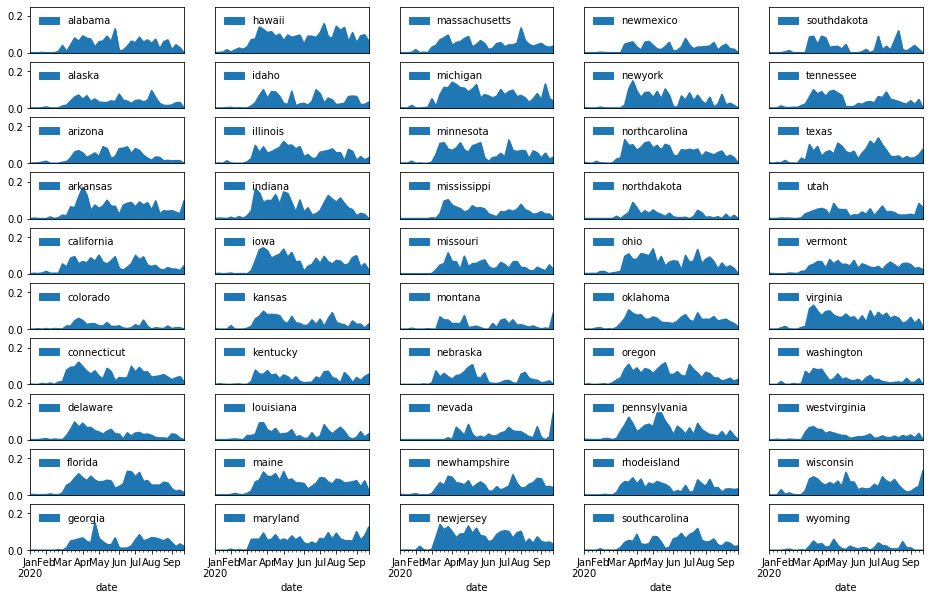

In [6]:
covid_mention = [CovidRelated(x) for x in comment_list]
metadat0['CovidRelated'] = covid_mention
metadat0['date'] = metadat0['TimeStamp'].dt.date


metadf2 = metadat0.groupby(['date','subreddit']).agg(
     # Count the number of posts on that particular date
    total_posts=('link_id', len),
    # Get sum of the posts mentioning covid
    total_covid=('CovidRelated', sum),
    # Apply a lambda to date column
    #num_days=("date", lambda x: (max(x) - min(x)).days)
).reset_index()

metadf2['subreddit'] = metadf2['subreddit'].apply(lambda x: x.lower())

metadf2 = metadf2[metadf2.total_posts > 20]
metadf2['p'] = metadf2['total_covid']/metadf2['total_posts']

meta_weekly = metadf2.pivot(index = 'date', columns='subreddit')['p'].fillna(0).resample('W').mean()

num_cols = 5
num_rows = 10

fig, axes = plt.subplots(ncols = num_cols, nrows = num_rows, figsize=(16,10))

ij = 0
for i in range(num_cols):
    for j in range(num_rows):
        colname = meta_weekly.columns.tolist()[ij]
        meta_weekly[[colname]].plot(kind='area', stacked=True, ax=axes[j,i], ylim = (0,0.25))
        axes[j,i].legend(loc='upper left', frameon = False)
        
        if i != 0:
            axes[j,i].axes.get_yaxis().set_visible(False)
        if j != num_rows-1:
            axes[j,i].axes.get_xaxis().set_visible(False)
        
        ij += 1

Merging P.I. with cases by 100

In [7]:
pop_by_state = pd.read_csv(data0_folder + 'nst-est2019-popchg2010_2019.csv')[['CODENAME','POPESTIMATE2019']]
pop_by_state = pop_by_state.append(pd.DataFrame([['NYC',8336817]], columns=['CODENAME', 'POPESTIMATE2019']))

POP_DICT = pd.Series(pop_by_state.POPESTIMATE2019.values, index=pop_by_state.CODENAME).to_dict()

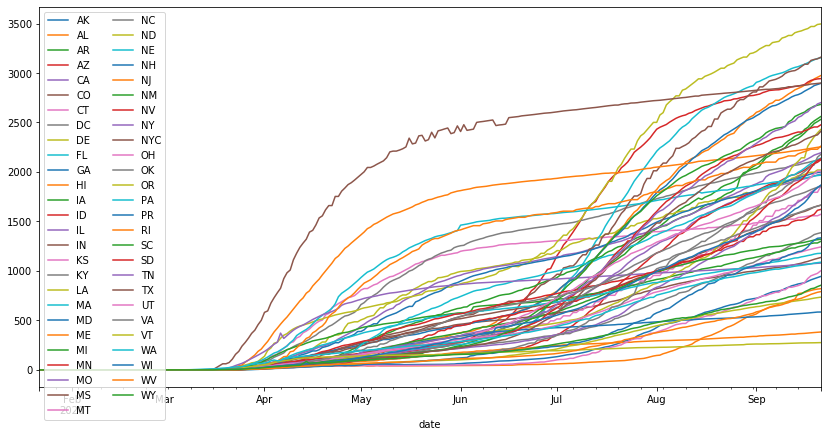

In [8]:
covid_by_state = pd.read_csv(data0_folder + 'United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')
covid_by_state.submission_date = pd.to_datetime(covid_by_state.submission_date, infer_datetime_format=True)

covid_by_state = covid_by_state.rename(columns={"submission_date": "date"})

covid_by_state = covid_by_state[['date', 'tot_cases', 'state']]
covid_by_state = covid_by_state.fillna(0)

index_to_remove = covid_by_state[covid_by_state.state.isin(states_to_remove)].index
covid_by_state.drop(index_to_remove, inplace = True)

covid_by_state['cases_by100K'] = 100000*(covid_by_state.tot_cases/covid_by_state.state.replace(POP_DICT))

covid_by_state.pivot(index = 'date', columns='state')['cases_by100K'].plot(figsize=(14,7))
plt.legend(loc='upper left',ncol=2)

In [9]:
metadf2 = metadf2.rename(columns={'subreddit':'state'})
metadf2.state = metadf2.state.replace(DICT_STATES_N2C)

In [12]:
df2 = pd.merge(metadf2.set_index(['date','state']),
         covid_by_state.set_index(['date','state']),
         how='outer', left_index=True, right_index=True).reset_index().sort_values(by=['date', 'state'])
df2.head()

,date,state,total_posts,total_covid,p,tot_cases,cases_by100K
0,2020-01-01,AK,113.0,0.0,0.0,NaN,NaN
1,2020-01-01,AL,39.0,0.0,0.0,NaN,NaN
2,2020-01-01,AR,59.0,0.0,0.0,NaN,NaN
3,2020-01-01,AZ,82.0,0.0,0.0,NaN,NaN
4,2020-01-01,CA,101.0,0.0,0.0,NaN,NaN


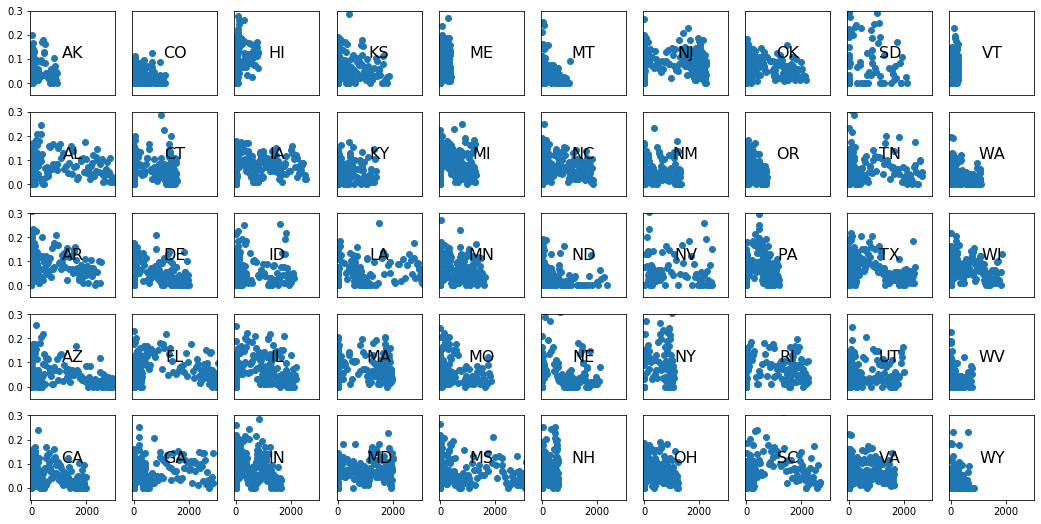

In [54]:
df2_bydate = df2.pivot(index = 'date', columns='state')[['p', 'cases_by100K']]

num_cols = 10
num_rows = 5

fig, axes = plt.subplots(ncols = num_cols, nrows = num_rows, figsize=(18,9))

states_names = df2_bydate['p'].columns.tolist()
CORR_DICT = {}
ij = 0
for i in range(num_cols):
    for j in range(num_rows):
        
        colname = states_names[ij]
        
        cases_by100K_ij = df2_bydate['cases_by100K'][colname]
        p_ij = df2_bydate['p'][colname]

        CORR_DICT[colname] = np.corrcoef(cases_by100K_ij, p_ij)
        
        axes[j,i].scatter(cases_by100K_ij, p_ij)
        axes[j,i].text(0.5, 0.5, colname, horizontalalignment='center',
             verticalalignment='center', transform=axes[j,i].transAxes, fontsize = 16)
        axes[j,i].set_xlim(-50,3050)
        axes[j,i].set_ylim(-0.05,0.30)
        
        if i != 0:
            axes[j,i].axes.get_yaxis().set_visible(False)
        if j != num_rows-1:
            axes[j,i].axes.get_xaxis().set_visible(False)
        
        ij += 1

In [148]:
results_elections = pd.read_csv(data0_folder + '1976-2016-president.csv')
results_elections.drop(results_elections[~(results_elections.year == 2016)].index, inplace = True)
results_elections['rel_vote'] = results_elections.candidatevotes/results_elections.totalvotes
# results_elections.drop(results_elections[~(results_elections.party.isin(['republican', 'democrat']))].index, inplace = True)
results_elections.drop(results_elections[~(results_elections.candidate.isin(['Trump, Donald J.', 'Clinton, Hillary']))].index, inplace = True)

results_elections.head(10)

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes,rel_vote
3395,2016,Alabama,AL,1,63,41,US President,"Trump, Donald J.",republican,False,1318255,2123372,20171015,NaN,0.620831
3396,2016,Alabama,AL,1,63,41,US President,"Clinton, Hillary",democrat,False,729547,2123372,20171015,NaN,0.343579
3400,2016,Alaska,AK,2,94,81,US President,"Trump, Donald J.",republican,False,163387,318608,20171015,NaN,0.512815
3401,2016,Alaska,AK,2,94,81,US President,"Clinton, Hillary",democrat,False,116454,318608,20171015,NaN,0.365509
3407,2016,Arizona,AZ,4,86,61,US President,"Trump, Donald J.",republican,False,1252401,2573165,20171015,NaN,0.486716
3408,2016,Arizona,AZ,4,86,61,US President,"Clinton, Hillary",democrat,False,1161167,2573165,20171015,NaN,0.451260
3417,2016,Arkansas,AR,5,71,42,US President,"Trump, Donald J.",republican,False,684872,1130635,20171015,NaN,0.605741
3418,2016,Arkansas,AR,5,71,42,US President,"Clinton, Hillary",democrat,False,380494,1130635,20171015,NaN,0.336531
3425,2016,California,CA,6,93,71,US President,"Clinton, Hillary",democrat,False,8753788,14181595,20171015,NaN,0.617264
3426,2016,California,CA,6,93,71,US President,"Trump, Donald J.",republican,False,4483810,14181595,20171015,NaN,0.316171
